In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchdyn.datasets import ToyDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.datasets import eight_gaussians, make_text_dataset

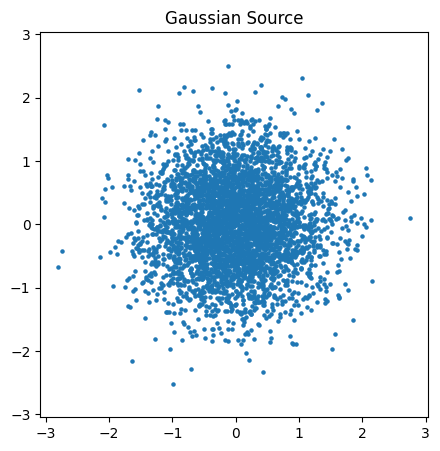

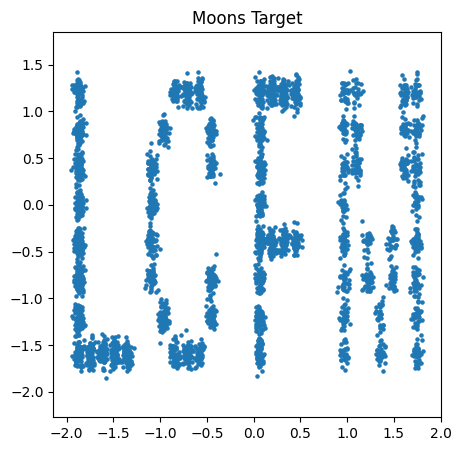

In [2]:

n_samples = 4000
data_dim = 2

x0 = torch.randn(n_samples, data_dim)/np.sqrt(data_dim)

word = "LCFM"
x1, labels = make_text_dataset(word,
                       n_samples=n_samples,
                       font_size=150,
                       noise_sigma=0.2,
                       char_spacing=1, normalize=True) # eight_gaussians(n_samples, data_dim, scale=5, var=0.1)
x1[:,1] += 2
x1[:,1] *= 2
x1[:,0] *= 2
t = torch.rand(n_samples, 1)
y = torch.nn.functional.one_hot(labels, num_classes=len(word)).float()

batch_size=256

dataset = TensorDataset(x0, x1, t, y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Visualize source & target
plt.figure(figsize=(5,5))
plt.scatter(x0[:,0], x0[:,1], s=5)
plt.title("Gaussian Source")
plt.axis("equal")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(x1[:,0], x1[:,1], s=5)
plt.title("Moons Target")
plt.axis("equal")
plt.show()

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        z_mean = self.fc_mu(h)
        z_logvar = self.fc_logvar(h)
        return z_mean, z_logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512)
        self.fc_out = nn.Linear(512, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc(z))
        x_reconst = torch.sigmoid(self.fc_out(h))
        return x_reconst

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, z_mean, z_logvar):
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)
        z = self.reparameterize(z_mean, z_logvar)
        x_reconst = self.decoder(z)
        return x_reconst, z_mean, z_logvar

In [4]:
device = 'cuda'
latent_dim = 4
vae = VAE(data_dim, latent_dim).to(device)

In [5]:
optimizer = optim.Adam(vae.parameters(), lr=1e-5)
criterion = nn.MSELoss()

def loss_function(x, x_reconst, z_mean, z_logvar):
    recon_loss = criterion(x_reconst, x)
    kl_div = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return recon_loss + kl_div

In [6]:
epochs = 1000
vae.train()

for epoch in tqdm(range(epochs)):
    total_loss = 0
    for _, x1_batch, _, _ in loader:
        x1 = x1_batch.to(device) 
        x_reconst, z_mean, z_logvar = vae(x1)
        loss = loss_function(x1, x_reconst, z_mean, z_logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss :.4f}")


  0%|          | 3/1000 [00:00<02:14,  7.39it/s]

Epoch 1, Loss: 1201.7840


 10%|█         | 103/1000 [00:06<00:51, 17.58it/s]

Epoch 101, Loss: 26.9533


 20%|██        | 203/1000 [00:12<00:45, 17.53it/s]

Epoch 201, Loss: 22.7222


 30%|███       | 303/1000 [00:18<00:38, 18.33it/s]

Epoch 301, Loss: 21.5256


 40%|████      | 403/1000 [00:24<00:32, 18.10it/s]

Epoch 401, Loss: 20.8774


 50%|█████     | 503/1000 [00:29<00:27, 17.77it/s]

Epoch 501, Loss: 20.5881


 60%|██████    | 603/1000 [00:35<00:23, 16.77it/s]

Epoch 601, Loss: 20.4144


 70%|███████   | 703/1000 [00:41<00:19, 15.33it/s]

Epoch 701, Loss: 20.3096


 80%|████████  | 803/1000 [00:46<00:10, 18.41it/s]

Epoch 801, Loss: 20.3071


 90%|█████████ | 903/1000 [00:52<00:05, 18.27it/s]

Epoch 901, Loss: 20.2905


100%|██████████| 1000/1000 [00:58<00:00, 17.17it/s]


In [7]:
for param in vae.parameters():
    param.requires_grad = False
    
for param in vae.encoder.fc_mu.parameters():
    param.requires_grad = True
    
for param in vae.encoder.fc_logvar.parameters():
    param.requires_grad = True

In [8]:
from typing import List

class Net(nn.Module):
    def __init__(self, in_dim: int, z_dim: int, out_dim: int, h_dims: List[int], n_frequencies: int) -> None:
        super().__init__()
        ins = [in_dim + 2 * n_frequencies + z_dim] + h_dims
        outs = h_dims + [out_dim]
        self.n_frequencies = n_frequencies
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU())
            for in_d, out_d in zip(ins, outs)
        ])
        self.top = nn.Sequential(nn.Linear(out_dim, out_dim))
    
    def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
        freq = 2 * torch.arange(self.n_frequencies, device=t.device) * torch.pi
        t_proj = t * freq[None, :]
        return torch.cat([t_proj.cos(), t_proj.sin()], dim=-1)
    
    def forward(self, t: torch.Tensor, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        te = self.time_encoder(t)
        h = torch.cat([x, te, z], dim=-1)
        for layer in self.layers:
            h = layer(h)
        return self.top(h)

model = Net(in_dim=data_dim, z_dim=latent_dim, out_dim=data_dim, h_dims=[128, 128], n_frequencies=4).to(device)
optimizer = optim.Adam(list(model.parameters()) + list(vae.encoder.fc_mu.parameters()) +
    list(vae.encoder.fc_logvar.parameters()), lr=1e-3)
loss_fn = nn.MSELoss()
num_epoches = 1000

In [9]:
loss_history = []
for epoch in tqdm(range(num_epoches)):
    total_loss = 0.0
    for x0_batch, x1_batch, t_b, y_b in loader:
        
        # Interpolated positions and true vector u_t
        xt = (1 - t_b) * x0_batch + t_b * x1_batch
        ut = x1_batch - x0_batch  # (x1_batch - x0_batch) / (t_batch * (1 - t_batch))
        xt, t_b, ut, x1 = [t.to(device) for t in (xt, t_b, ut, x1_batch)]
        
        z_mean, z_logvar = vae.encoder(x1)
        z_b = vae.reparameterize(z_mean, z_logvar)
        # z_b = torch.randint(1,(y_b.shape[0],2)).to(device)
        y_b = y_b.to(device)
        
        optimizer.zero_grad()
        v_pred = model(t_b, xt, z_b)
        loss = loss_fn(v_pred, ut)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * xt.size(0)
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss :.4f}")
    loss_history.append(total_loss / n_samples)

  0%|          | 4/1000 [00:00<00:57, 17.28it/s]

Epoch 1, Loss: 8332.4388


 10%|█         | 104/1000 [00:06<00:50, 17.78it/s]

Epoch 101, Loss: 551.7916


 20%|██        | 204/1000 [00:12<00:47, 16.61it/s]

Epoch 201, Loss: 260.6772


 30%|███       | 304/1000 [00:18<00:42, 16.22it/s]

Epoch 301, Loss: 163.7179


 40%|████      | 404/1000 [00:24<00:40, 14.89it/s]

Epoch 401, Loss: 121.8765


 50%|█████     | 504/1000 [00:30<00:27, 18.02it/s]

Epoch 501, Loss: 100.6595


 60%|██████    | 604/1000 [00:36<00:22, 17.93it/s]

Epoch 601, Loss: 78.5951


 70%|███████   | 704/1000 [00:41<00:16, 17.84it/s]

Epoch 701, Loss: 72.1045


 80%|████████  | 804/1000 [00:47<00:11, 17.80it/s]

Epoch 801, Loss: 73.8373


 90%|█████████ | 904/1000 [00:53<00:05, 17.39it/s]

Epoch 901, Loss: 55.7678


100%|██████████| 1000/1000 [00:59<00:00, 16.85it/s]


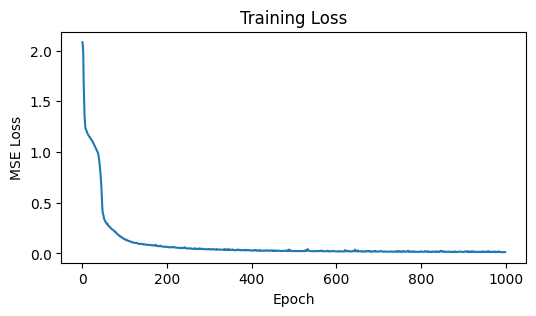

In [10]:
# Cell 4: Plot training loss
plt.figure(figsize=(6,3))
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [13]:
def euler_integration(x0, z, model, steps=100):
    x0 = x0.unsqueeze(0)
    traj = [x0]
    z = z.unsqueeze(0).to(device).to(x0.dtype)
    
    x = x0.clone().to(device)
    dt = 1.0 / steps
    for i in range(steps):
        t_i = torch.tensor([[i * dt]], device=device)
        with torch.no_grad():
            # print(t_i.shape, x.shape, z.shape)
            v = model(t_i, x, z)
        x = x + v * dt
        traj.append(x.cpu().numpy())
    return np.stack(traj).squeeze()

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import torch
import os

def generate_gif(model, x0_vis, x1_vis, z_b, steps=20, save_path="flow.gif", N=100, plot_traj=True, plot_init=True):
    frames = []
    all_trajectories = []

    # Precompute axis limits from the initial points
    all_pts = np.concatenate([x0_vis, x1_vis], axis=0)
    x_min, x_max = all_pts[:, 0].min() - 0.5, all_pts[:, 0].max() + 0.5
    y_min, y_max = all_pts[:, 1].min() - 0.5, all_pts[:, 1].max() + 0.5

    # Compute trajectories
    for i in tqdm(range(N)):
        traj = euler_integration(x0_vis[i], z_b[i], model, steps=steps)
        all_trajectories.append(traj)

    # Render each step
    for step in range(steps + 1):
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title(f"Flow step {step}")

        if plot_init:
            ax.scatter(x0_vis[:, 0], x0_vis[:, 1], label='Initial', marker='o', s=4)
        ax.scatter(x1_vis[:, 0], x1_vis[:, 1], label='Target Mean', marker='x', c='r')

        for traj in all_trajectories:
            if step < len(traj):
                if plot_traj:
                    ax.plot(traj[:step+1, 0], traj[:step+1, 1], color='grey', alpha=0.1)
                ax.scatter(traj[step, 0], traj[step, 1], marker='x', color='blue', s=10)

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_aspect('equal')
        ax.legend()
        plt.tight_layout()

        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)

    imageio.mimsave(save_path, frames, duration=0.1)

In [27]:
import random
from torch.utils.data import Subset, DataLoader

N = 1024   # how many trajectories you want

# 1) Randomly choose N indices from the full dataset
all_indices = list(range(len(dataset)))
chosen = random.sample(all_indices, N)

# 2) Build a Subset and DataLoader that's exactly those N samples
subset      = Subset(dataset, chosen)
viz_loader  = DataLoader(subset, batch_size=N, shuffle=False)

# 3) Pull out that single batch of N samples
x0_vis, x1_vis, t_vis, y_vis = next(iter(viz_loader))  
# shapes: [N,2], [N,2], [N,1], [N,4]  (for your "LCFM" one-hot)

# 4) Encode x1_vis through your pretrained VAE to get z’s
x1_vis = x1_vis.to(device)
with torch.no_grad():
    mu, logvar = vae.encoder(x1_vis)
    z_vis = vae.reparameterize(mu, logvar)   # [N, latent_dim]

# 5) Now call your GIF routine with exactly these N points
generate_gif(
    model,
    x0_vis,
    x1_vis.cpu(),
    z_vis.cpu(),
    steps=32,
    save_path="flow_cmf.gif",
    N=N,
    plot_traj=False,
    plot_init=False
)


100%|██████████| 1024/1024 [00:08<00:00, 115.33it/s]
/tmp/ipykernel_3663301/3385290998.py:43: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
